In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:
embeddings = np.load("/home/lalo/PycharmProjects/explanaible-steam-nlp/data/embeddings1.npy")
labels = np.load("/home/lalo/PycharmProjects/explanaible-steam-nlp/data/labels_mapped1.npy")
X = np.array(embeddings)
y = np.array(labels)

# conjunto 80 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# validacion
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de X_test: {X_test.shape}")

# convertir tensores con pytorch
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

#dataloaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Forma de X_train: (1584857, 384)
Forma de X_val: (176096, 384)
Forma de X_test: (440239, 384)


In [ ]:
#modelo
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # capa de entrada
        self.fc1 = nn.Linear(384, 128)
        # dropout para evitar sobreajuste
        self.dropout1 = nn.Dropout(0.3)
        # oculta
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        # capa de salida con una sola neurona con sigmoid para clasificacion binaria
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# gpu revisar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

model = BinaryClassifier().to(device)

Usando dispositivo: cpu


In [ ]:

#compilar, un buen optimizador (segun nuestro profesor y yo le creo)
optimizer = optim.Adam(model.parameters())
# perdida estandar para clasificacion binaria
criterion = nn.BCELoss()


In [ ]:
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
#entrenamiento
epochs = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.size(0)

    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    #validacion
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}')


Epoch 1/10 - Loss: 0.4215 - Acc: 0.7879 - Val_Loss: 0.3978 - Val_Acc: 0.7991
Epoch 2/10 - Loss: 0.4054 - Acc: 0.7966 - Val_Loss: 0.3913 - Val_Acc: 0.8037
Epoch 3/10 - Loss: 0.4000 - Acc: 0.7995 - Val_Loss: 0.3891 - Val_Acc: 0.8047
Epoch 4/10 - Loss: 0.3969 - Acc: 0.8014 - Val_Loss: 0.3866 - Val_Acc: 0.8058
Epoch 5/10 - Loss: 0.3940 - Acc: 0.8028 - Val_Loss: 0.3850 - Val_Acc: 0.8074
Epoch 6/10 - Loss: 0.3924 - Acc: 0.8035 - Val_Loss: 0.3851 - Val_Acc: 0.8067
Epoch 7/10 - Loss: 0.3908 - Acc: 0.8048 - Val_Loss: 0.3834 - Val_Acc: 0.8080
Epoch 8/10 - Loss: 0.3894 - Acc: 0.8054 - Val_Loss: 0.3827 - Val_Acc: 0.8086
Epoch 9/10 - Loss: 0.3884 - Acc: 0.8056 - Val_Loss: 0.3827 - Val_Acc: 0.8082
Epoch 10/10 - Loss: 0.3876 - Acc: 0.8064 - Val_Loss: 0.3814 - Val_Acc: 0.8089


In [ ]:
#evaluar en el conjunto de prueba
model.eval()
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

with torch.no_grad():
    y_pred_prob = model(X_test_t)
    test_loss = criterion(y_pred_prob, y_test_t)
    y_pred_class = (y_pred_prob > 0.5).float()
    test_acc = (y_pred_class == y_test_t).sum().item() / y_test_t.size(0)

print(f"\nPerdida en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc*100:.2f}%")

y_pred_prob = y_pred_prob.cpu().numpy()
y_pred_class = y_pred_class.cpu().numpy().astype(int)


Perdida en test: 0.3828
Accuracy en test: 80.82%



Gráfica guardada


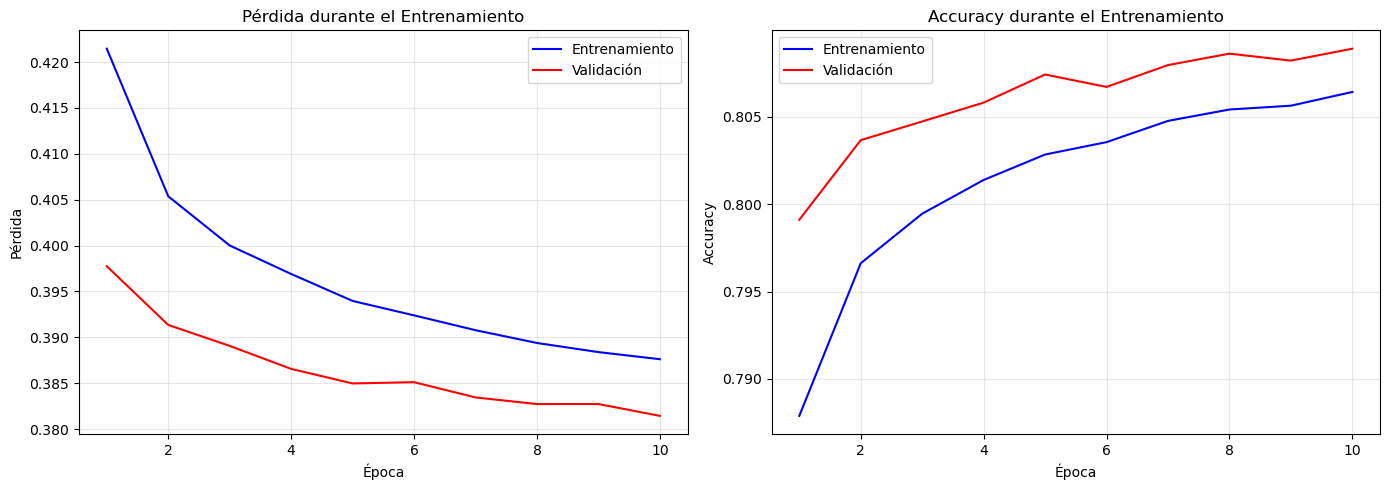

Modelo guardado


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# grafica de perdida
axes[0].plot(range(1, epochs+1), train_losses, 'b-', label='Entrenamiento')
axes[0].plot(range(1, epochs+1), val_losses, 'r-', label='Validación')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Pérdida durante el Entrenamiento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# grafica de accuracy
axes[1].plot(range(1, epochs+1), train_accs, 'b-', label='Entrenamiento')
axes[1].plot(range(1, epochs+1), val_accs, 'r-', label='Validación')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy durante el Entrenamiento')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
print("\nGráfica guardada")
plt.show()

# guardar modelo
torch.save(model.state_dict(), '/home/lalo/PycharmProjects/explanaible-steam-nlp/data/modelo_pytorch.pth')
print("Modelo guardado")